In [2]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [3]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [4]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [5]:
%matplotlib inline

In [6]:
%store -r X_motion_step
%store -r Y_motion_step
print(X_motion_step.shape)
print(Y_motion_step.shape)

(148884, 37)
(148884, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_rl_swinging = np.where(X_motion_step[:, 24] == 1)[0]
X_motion_step_RL = X_motion_step[idx_rl_swinging]
Y_motion_step_RL = Y_motion_step[idx_rl_swinging]

## Predict RL foot -> x

In [9]:
X_motion_step_RL[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.73259492e-08,  8.26137569e-09,
       -2.31107939e-43,  2.55124842e-26, -1.29773315e-23,  4.71751457e-03,
        1.56884253e-01,  1.33104801e-01, -3.39981973e-01,  1.92550018e-01,
       -1.40392303e-01, -3.33698064e-01, -2.76241094e-01,  1.40536815e-01,
       -3.36472392e-01, -2.58489013e-01, -1.30886346e-01, -3.38354051e-01,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.23098426e-02, -4.47599696e-03,
        1.79496527e-01])

In [10]:
Y_motion_step_RL[0, :]

array([ 0.        ,  0.        ,  0.01586381, -0.00457941,  0.02445424,
        0.00146174,  0.        ,  0.        ])

In [11]:
Y_motion_step_RL.shape

(75769, 8)

In [12]:
#X_motion_step[idx_rl_swinging - 1, 28]

### Linear Regression

In [19]:
# Input
#X = np.hstack((X_motion_step_RL[:, :2], np.array([X_motion_step_RL[:, 5]]).T, 
#               X_motion_step_RL[:, 6:8], np.array([X_motion_step_RL[:, 11]]).T, 
#               np.array([X_motion_step_RL[:, 18]]).T, np.array([X_motion_step_RL[:, 21]]).T))
X = np.hstack((X_motion_step_RL[:, :2], np.array([X_motion_step_RL[:, 5]]).T, 
               np.array([X_motion_step_RL[:, 18]]).T, np.array([X_motion_step_RL[:, 21]]).T))

X = np.hstack((X_motion_step_RL[:, :2], 
               np.array([X_motion_step_RL[:, 5]]).T,
               np.array([X_motion_step[idx_rl_swinging-1, 30]]).T, 
               np.array([X_motion_step[idx_rl_swinging, 32]]).T,
               X_motion_step[idx_rl_swinging, 34:36]))

# Labels
Y = np.array([Y_motion_step_RL[:, 4]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_rl_x = LinearRegression()

# Fit the model
model_rl_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9733096777679622
RMSE:  0.01597903362087659
The lowest error is:  3.737696835925952e-06
The highest error is:  0.14064424405829556
The avg. error is:  0.011415749740476839


Text(0, 0.5, 'Predictions')

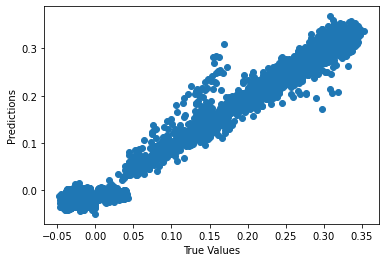

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [21]:
%store model_rl_x

Stored 'model_rl_x' (LinearRegression)


In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
joblib.dump(model_rl_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rl_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rl_x.sav']

### Predict FL foot -> y

In [22]:
# Input
#X = np.hstack((X_motion_step_RL[:, :2], np.array([X_motion_step_RL[:, 5]]).T, 
#               X_motion_step_RL[:, 6:8], np.array([X_motion_step_RL[:, 11]]).T, 
#               np.array([X_motion_step_RL[:, 19]]).T, np.array([X_motion_step_RL[:, 22]]).T))
X = np.hstack((X_motion_step_RL[:, :2], np.array([X_motion_step_RL[:, 5]]).T, 
               np.array([X_motion_step_RL[:, 19]]).T, np.array([X_motion_step_RL[:, 22]]).T))

X = np.hstack((X_motion_step_RL[:, :2], 
               np.array([X_motion_step_RL[:, 5]]).T,
               np.array([X_motion_step[idx_rl_swinging-1, 31]]).T, 
               np.array([X_motion_step[idx_rl_swinging, 33]]).T,
               X_motion_step[idx_rl_swinging, 34:36]))

# Labels
Y = np.array([Y_motion_step_RL[:, 5]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_rl_y = LinearRegression()

# Fit the model
model_rl_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9893967987440347
RMSE:  0.01028849004873157
The lowest error is:  1.1040322624444876e-06
The highest error is:  0.08742244455610562
The avg. error is:  0.0073486915170769065


Text(0, 0.5, 'Predictions')

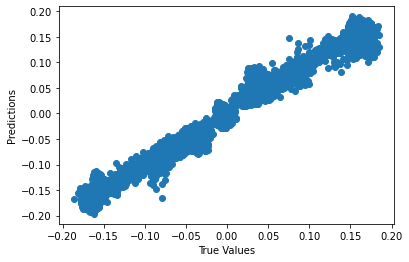

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [24]:
%store model_rl_y

Stored 'model_rl_y' (LinearRegression)


In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [21]:
# Save model
joblib.dump(model_rl_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rl_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rl_y.sav']